In [1]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !echo '{"username":"your_username","key":"your_api_key"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:40<00:00, 187MB/s]
100% 3.75G/3.75G [00:40<00:00, 99.9MB/s]


In [3]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
 96% 412M/431M [00:02<00:00, 215MB/s]
100% 431M/431M [00:02<00:00, 212MB/s]


In [4]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [5]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )

    return model


In [6]:
base_path = '/content/dataset/real_vs_fake/real-vs-fake/train'
image_gen = ImageDataGenerator(rescale=1./255.,
                               rotation_range=20,
                               #shear_range=0.2,
                               #zoom_range=0.2,
                               horizontal_flip=True)

# Fix: Remove the extra 'train/' from the directory path
train_flow = image_gen.flow_from_directory(
    base_path,  # Use the base_path directly
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [7]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

# Update the path to the validation directory
valid_flow = image_gen1.flow_from_directory(
    '/content/dataset/real_vs_fake/real-vs-fake/valid', # Updated path for validation data
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9601s 3s/step - accuracy: 0.6509 - loss: 0.6231 - val_accuracy: 0.7556 - val_loss: 0.5010
Epoch 2/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9506s 3s/step - accuracy: 0.7624 - loss: 0.4920 - val_accuracy: 0.7837 - val_loss: 0.4598
Epoch 3/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9485s 3s/step - accuracy: 0.8033 - loss: 0.4283 - val_accuracy: 0.8335 - val_loss: 0.3704
Epoch 4/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9496s 3s/step - accuracy: 0.8289 - loss: 0.3812 - val_accuracy: 0.8550 - val_loss: 0.3329


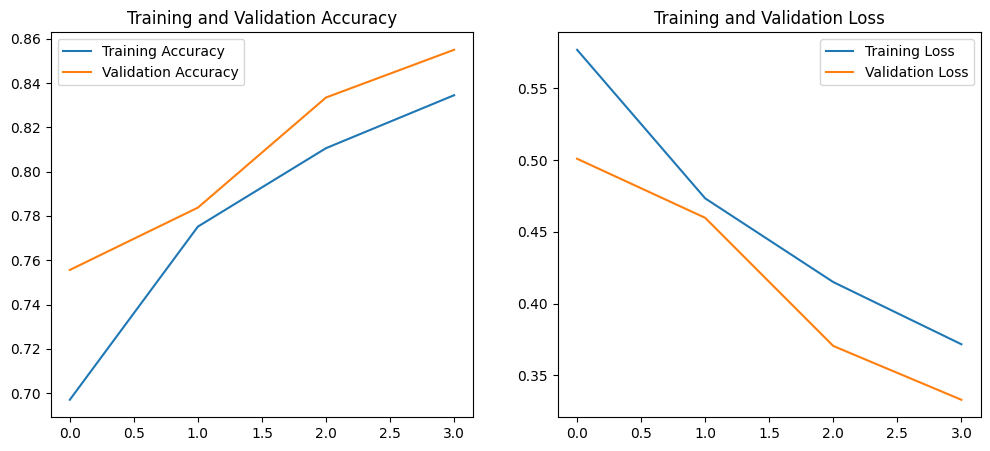

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 530s 26ms/step
ROC AUC Score: 0.9326281750000001
AP Score: 0.9295760597249108
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     10000
           1       0.87      0.84      0.86     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



In [8]:
# Install required libraries
!pip install keras-vggface opencv-python tqdm

# Import necessary libraries
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
# Instead of: from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Use tensorflow.keras for ImageDataGenerator
from sklearn import metrics

# Dataset paths
base_path = '/content/dataset/real_vs_fake/real-vs-fake/'

# Data Generators
batch_size = 32  # Reduced batch size for CPU optimization
image_gen = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

image_gen1 = ImageDataGenerator(rescale=1./255.)
valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

# Model Definition
model = Sequential()
input_shape = (224, 224, 3)
activation = 'relu'
padding = 'same'
droprate = 0.1

model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(16, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(64, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(128, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(256, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the Model
train_steps = len(train_flow)
valid_steps = len(valid_flow)
history = model.fit(
    train_flow,
    epochs=4,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps
)

# Save the Model
model.save("custom_model_cpu_optimized.h5")

# Plot Training and Validation Loss/Accuracy
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

# Evaluate on Test Data
y_pred = model.predict(test_flow)
y_test = test_flow.classes

print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred > 0.5))


In [9]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to compute Grad-CAM heatmap
def get_gradcam_heatmap(model, image, last_conv_layer_index, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.

    Parameters:
      model: The trained Keras model.
      image: Input image (of shape [height, width, channels]) normalized as in training.
      last_conv_layer_index: The index of the last convolutional layer in the model.
      pred_index: Index of the class to explain (optional). If None, uses the model's predicted class.

    Returns:
      heatmap: A 2D numpy array with values between 0 and 1.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.layers[last_conv_layer_index].output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # ReLU on heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Function to overlay the heatmap on the image
def overlay_heatmap_on_image(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlays the Grad-CAM heatmap onto the original image.

    Parameters:
      image: The original image as a uint8 array.
      heatmap: The heatmap as a numpy array.
      alpha: Transparency factor for the heatmap overlay.
      colormap: OpenCV colormap to apply.

    Returns:
      output_image: The image with the heatmap overlay.
    """
    # Resize heatmap to match image dimensions
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return output_image

# Select one test image from your test_flow
# (Assuming test_flow has been defined earlier using your ImageDataGenerator)
test_batch = next(test_flow)  # This returns (images, labels)
test_image = test_batch[0][0]  # Extract first image; shape: (224, 224, 3)
# Note: test_image is normalized (values in [0,1]); for display we convert it later.

# Compute Grad-CAM heatmap.
# In your Sequential model, the last conv layer is at index 16 (check your model structure).
last_conv_layer_index = 16  # Adjust if necessary.
heatmap = get_gradcam_heatmap(model, test_image, last_conv_layer_index)

# Convert test image to uint8 for visualization
orig_image = np.uint8(test_image * 255)

# Get overlay image
overlay = overlay_heatmap_on_image(orig_image, heatmap, alpha=0.4)

# Plot the XAI chart: Original image, Grad-CAM heatmap, and Overlay.
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(orig_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
# OpenCV uses BGR; convert overlay from BGR to RGB for matplotlib display.
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay")
plt.axis("off")

plt.suptitle("Explainable AI (XAI) using Grad-CAM", fontsize=16)
plt.show()


AttributeError: The layer sequential has never been called and thus has no defined output.

In [ ]:
# Install required libraries
!pip install keras-vggface opencv-python tqdm

# Import necessary libraries
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
# Instead of: from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Use tensorflow.keras for ImageDataGenerator
from sklearn import metrics

# Dataset paths
base_path = '/content/dataset/real_vs_fake/real-vs-fake/'

# Data Generators
batch_size = 32  # Reduced batch size for CPU optimization
image_gen = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

image_gen1 = ImageDataGenerator(rescale=1./255.)
valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

# Model Definition
model = Sequential()
input_shape = (224, 224, 3)
activation = 'relu'
padding = 'same'
droprate = 0.1

model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(16, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(64, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(128, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(256, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the Model
train_steps = len(train_flow)
valid_steps = len(valid_flow)
history = model.fit(
    train_flow,
    epochs=5,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps
)

# Save the Model
model.save("custom_model_cpu_optimized.h5")

# Plot Training and Validation Loss/Accuracy
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

# Evaluate on Test Data
y_pred = model.predict(test_flow)
y_test = test_flow.classes

print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred > 0.5))


In [ ]:
# Install required libraries
# !pip install tensorflow opencv-python tqdm scikit-learn matplotlib seaborn

# import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# import matplotlib.pyplot as plt
# from sklearn import metrics
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # -------------------------------
# # 1. Data Preparation
# # -------------------------------
# base_path = '/content/dataset/real_vs_fake/real-vs-fake/'
# batch_size = 32
# target_size = (224, 224)

# # Aggressive data augmentation for training
# train_datagen = ImageDataGenerator(
#     rescale=1./255.,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2
# )
# # Simple rescaling for validation and test
# val_datagen = ImageDataGenerator(rescale=1./255.)
# test_datagen = ImageDataGenerator(rescale=1./255.)

# train_flow = train_datagen.flow_from_directory(
#     base_path + 'train/',
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='binary'
# )
# val_flow = val_datagen.flow_from_directory(
#     base_path + 'valid/',
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='binary'
# )
# test_flow = test_datagen.flow_from_directory(
#     base_path + 'test/',
#     target_size=target_size,
#     batch_size=1,
#     shuffle=False,
#     class_mode='binary'
# )

# # -------------------------------
# # 2. Build the Model using MobileNetV2 (Transfer Learning)
# # -------------------------------
# # Load the base model with pretrained ImageNet weights.
# base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
# base_model.trainable = False  # Freeze for initial training

# # Add a custom classification head.
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)  # Use high dropout to help generalization
# predictions = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model (initial phase)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# # -------------------------------
# # 3. Callbacks & Training Settings
# # -------------------------------
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
#     ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
# ]

# # Limit steps per epoch to use only a subset of the full generator (reduce from ~3125 to 2000)
# steps_per_epoch = 2000
# validation_steps = min(50, len(val_flow))  # Adjust as needed

# # -------------------------------
# # 4. Phase 1: Feature Extraction (Frozen Base)
# # -------------------------------
# initial_epochs = 5
# history_initial = model.fit(
#     train_flow,
#     epochs=initial_epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_flow,
#     validation_steps=validation_steps,
#     callbacks=callbacks,
#     verbose=1
# )

# # -------------------------------
# # 5. Phase 2: Fine-Tuning (Unfreeze Last Layers)
# # -------------------------------
# # Unfreeze the last 30 layers of the base model for fine-tuning.
# base_model.trainable = True
# for layer in base_model.layers[:-30]:
#     layer.trainable = False

# # Recompile with a lower learning rate for fine-tuning.
# model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# # Increase fine-tuning epochs so that total epochs = initial_epochs + fine_tune_epochs = 5 + 15 = 20
# fine_tune_epochs = 15
# total_epochs = initial_epochs + fine_tune_epochs
# history_fine = model.fit(
#     train_flow,
#     epochs=total_epochs,
#     initial_epoch=initial_epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_flow,
#     validation_steps=validation_steps,
#     callbacks=callbacks,
#     verbose=1
# )

# model.save("mobilenetv2_finetuned.h5")

# # -------------------------------
# # 6. Plot Training Metrics
# # -------------------------------
# # Combine histories for plotting
# train_acc = history_initial.history['accuracy'] + history_fine.history['accuracy']
# val_acc = history_initial.history['val_accuracy'] + history_fine.history['val_accuracy']
# train_loss = history_initial.history['loss'] + history_fine.history['loss']
# val_loss = history_initial.history['val_loss'] + history_fine.history['val_loss']

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_acc, label='Train Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_loss, label='Train Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

# # -------------------------------
# # 7. Evaluate on Test Data & Generate Confusion Matrix
# # -------------------------------
# y_pred = model.predict(test_flow)
# y_test = test_flow.classes
# roc_auc = metrics.roc_auc_score(y_test, y_pred)
# ap_score = metrics.average_precision_score(y_test, y_pred)

# print("ROC AUC Score:", roc_auc)
# print("Average Precision Score:", ap_score)
# print(metrics.classification_report(y_test, y_pred > 0.5))

# # Confusion Matrix
# y_pred_class = (y_pred > 0.5).astype("int32")
# cm = confusion_matrix(y_test, y_pred_class)
# print("Confusion Matrix:\n", cm)

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()
